In [31]:
import os
import re

os.chdir("/home/s2113174/Projects-1")

from Galab import llaplace

import torch
from torch.autograd import Variable, grad
from torch import linalg as LA

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from pyDOE import lhs
import scipy.io

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Heat Equation

$$\frac{\partial u}{\partial t} = k \frac{\partial^{2} u}{\partial x^{2}} + sin(5 \pi x)$$
$$u(x,0) = 4sin(3 \pi x)+ 9sin(7 \pi x),  u(0,t)=u(1,t)=0$$

In [32]:
def exact_solution(x,t,theta):
    u = 4*np.sin(3*np.pi*x)*np.exp(-theta*((3*np.pi)**2)*t) + 9*np.sin(7*np.pi*x)*np.exp(-theta*((7*np.pi)**2)*t) + \
    (1/(25*(np.pi**2)*theta))*np.sin(5*np.pi*x)*np.exp(-theta*((5*np.pi)**2)*t) - (1/(25*(np.pi**2)*theta))*np.sin(5*np.pi*x)
    return u    

## Feed Forward Neural Network

In [33]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Heat Equation definition for the NN

In [34]:
def de(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)
    
    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = du[:,1].reshape(-1,1) - data_domain[:,2].reshape(-1,1)*ddu_x[:,0].reshape(-1,1)- torch.sin(5*torch.pi*data_domain[:,0].reshape(-1,1))

    return f

def ini_c(self,data_inic):
    u = self(data_inic)
    return u - 4*torch.sin(3*torch.pi*data_inic[:,0].reshape(-1,1)) - 9*torch.sin(7*torch.pi*data_inic[:,0].reshape(-1,1))

def left_bc(self,data_lbc):
    u = self(data_lbc)
    return u

def right_bc(self,data_rbc):
    u = self(data_rbc)
    return u

In [35]:
DNN.de = de
DNN.ini_c = ini_c
DNN.left_bc = left_bc
DNN.right_bc = right_bc

In [36]:
def samples_space(size,maxl):
    t_f_train = lhs(2, size)*maxl
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [37]:
def data_pde(size,maxl,minp,maxp):

    xy, param = samples_space(size,maxl),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    ini_c = torch.cat([x,torch.zeros_like(x).float(),param],axis = 1).float()

    left_bc = torch.cat([torch.zeros_like(x).float(),y, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(),y, param],axis = 1).float()

    return pde_domain,ini_c,left_bc,right_bc

In [38]:
# Number of observations
epochs = 1200
lr = 0.01

min_param, max_param, space = 0.0001, 0.05,1

x, y = np.linspace(0,1,100), np.linspace(0,1.5,100)

xx,yy = np.meshgrid(x, y)
layers = [3] + 3*[40] + [1]

In [39]:
laplace_approx =  []
for obs in [100,1000,1500,2000]:
        
        pde_domain,ini_c,left_bc,right_bc = data_pde(obs,space,min_param,max_param)

        pde = {"PDE":["de","ini_c","left_bc","right_bc"], 
            "data_set":{"de" : Variable(pde_domain,requires_grad=True),
                        "ini_c" : ini_c,
                        "left_bc":left_bc,
                        "right_bc" :right_bc}}
        model = DNN(layers)
        
        path = f"../Projects-1/Physics _Informed_NN/GaLA/Gala_models/HeatEq__"+str(obs) +".pt"

        model.load_state_dict(torch.load(path))
        model.eval()

        llp = llaplace(model)
        llp.fit(pde=pde, hessian_structure = "full")

        log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
        hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
        
        for i in range(1000):
            hyper_optimizer.zero_grad()
            neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
            neg_marglik.backward(retain_graph=True)
            hyper_optimizer.step()
        print(f"NN: observations {obs}, sigma {llp.sigma_noise.detach().numpy()} and prior prec {llp.prior_precision.detach().numpy()}")

        laplace_approx.append(llp)


NN: observations 100, sigma [9.903393] and prior prec [0.01336442]
NN: observations 1000, sigma [2.2487905] and prior prec [0.09155849]
NN: observations 1500, sigma [0.4804071] and prior prec [0.23618178]
NN: observations 2000, sigma [0.70162314] and prior prec [0.18047948]


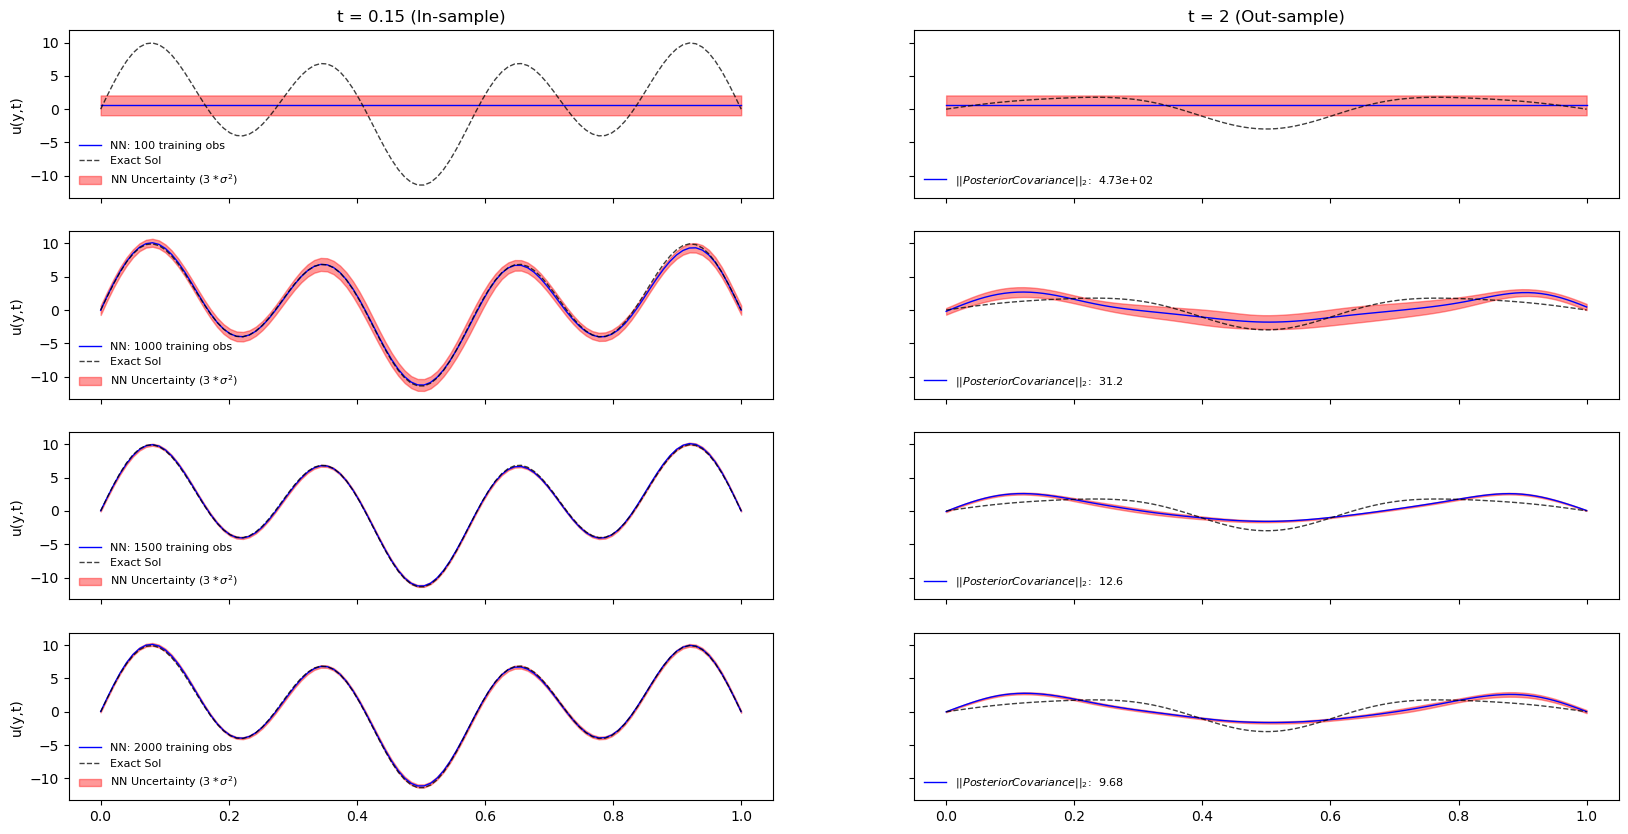

In [40]:
# pr =  np.array([0.005])
# fig, axs = plt.subplots(4, 2, figsize=(20,10), sharey=True,sharex=True)
# plt.rcParams.update({'font.size': 10})

# nobs =[100,1000,1500,2000]
# for counter,(llp,obs) in enumerate(zip(laplace_approx,nobs)):
        
#         pcovariance = LA.norm(llp.posterior_covariance)

#         X_star = torch.cat([torch.tensor(xx).reshape(-1,1),torch.tensor(yy).reshape(-1,1),torch.ones(xx.reshape(-1,1).shape)*pr],axis = 1).float()

#         f_mu, f_sigma = llp(X_star)

#         f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()
        

#         z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.flatten(), (xx,yy), method='cubic')
#         z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')
#         #z_pred_var = np.sqrt(z_pred_var**2 + llp.sigma_noise.item()**2)

#         z_exact =  exact_solution(xx,yy,pr)

#         axs[0,0].set_title(fr"t = 0.15 (In-sample)",color = "black")
#         axs[counter,0].plot(x,z_pred[5,:],color = "blue", label = f"NN: {obs} training obs",linewidth=1)
#         axs[counter,0].plot(x,z_exact[5,:],linestyle = "--",alpha = 0.75,color = "black", label = "Exact Sol",linewidth=1)
#         axs[counter,0].fill_between(x, z_pred[5,:]+3*z_pred_var[5,:],z_pred[5,:]-3*z_pred_var[5,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($3*\sigma^{2})$")
#         axs[counter,0].legend(frameon = False, prop={'size': 8},loc='lower left')
#         axs[counter,0].set_ylabel(r'u(y,t)')

#         axs[0,1].set_title(fr"t = 2 (Out-sample)",color = "black")
#         axs[counter,1].plot(x,z_pred[-1,:],color = "blue",linewidth=1,label = fr"$||Posterior Covariance||_{2}$: {pcovariance: 0.3}")
#         axs[counter,1].plot(x,z_exact[-1,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=1)
#         axs[counter,1].fill_between(x, z_pred[-1,:]+3*z_pred_var[-1,:],z_pred[-1,:]-3*z_pred_var[-1,:],alpha=0.4, color = "red")
#         axs[counter,1].legend(frameon = False, prop={'size': 8})
#         axs[counter,1].legend(frameon = False, prop={'size': 8},loc='lower left')

In [41]:
# nobs = 2000

# pde_domain,ini_c,left_bc,right_bc = data_pde(nobs,space,min_param,max_param)

# pde = {"PDE":["de","ini_c","left_bc","right_bc"], 
#        "data_set":{"de" : Variable(pde_domain,requires_grad=True),
#                    "ini_c" : ini_c,
#                    "left_bc":left_bc,
#                    "right_bc" :right_bc}}

# laplace_approx =  []
# for layer in [2,3,4]:
#     for neuron in [20,30,40]:

#         layers = [3] + layer*[neuron] + [1]

#         model = DNN(layers)

#         model.load_state_dict(torch.load(f"../Projects-1/Physics _Informed_NN/GaLA/Gala_models/HeatEq_{layer}_{neuron}.pt"))
#         model.eval()

#         llp = llaplace(model,sigma_noise=10, prior_precision=1)
#         llp.fit(pde=pde, hessian_structure = "full")

#         log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
#         hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
        
#         for i in range(1000):
#             hyper_optimizer.zero_grad()
#             neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
#             neg_marglik.backward(retain_graph=True)
#             hyper_optimizer.step()
#         print(f"NN: layer {layer} and neurons {neuron}, sigma {llp.sigma_noise.detach().numpy()} and prior prec {llp.prior_precision.detach().numpy()}")

#         laplace_approx.append(llp)


In [42]:
# pr =  np.array([0.05])
# fig, axs = plt.subplots(9, 2, figsize=(20,20), sharey=True,sharex=True)
# plt.rcParams.update({'font.size': 10})

# arch = [(2,20),(2,30),(2,40),(3,20),(3,30),(3,40),(4,20),(4,30),(4,40)]
# for counter,(llp,ar) in enumerate(zip(laplace_approx,arch)):
#         layer, neuron = ar
        
#         pcovariance = LA.norm(llp.posterior_covariance)

#         X_star = torch.cat([torch.tensor(xx).reshape(-1,1),torch.tensor(yy).reshape(-1,1),torch.ones(xx.reshape(-1,1).shape)*pr],axis = 1).float()

#         f_mu, f_sigma = llp(X_star)

#         f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()
        

#         z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.flatten(), (xx,yy), method='cubic')
#         z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')
#         #z_pred_var = np.sqrt(z_pred_var**2 + llp.sigma_noise.item()**2)

#         z_exact = exact_solution(xx,yy,pr)

#         axs[0,0].set_title(fr"t = 0.15 (In-sample)",color = "black")
#         axs[counter,0].plot(x,z_pred[10,:],color = "blue", label = f"NN: {layer} layers, and {neuron} neurons",linewidth=1)
#         axs[counter,0].plot(x,z_exact[10,:],linestyle = "--",alpha = 0.75,color = "black", label = "Exact Sol",linewidth=1)
#         axs[counter,0].fill_between(x, z_pred[10,:]+3*z_pred_var[10,:],z_pred[10,:]-3*z_pred_var[10,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($3*\sigma^{2})$")
#         axs[counter,0].legend(frameon = False, prop={'size': 8},loc='lower left')
#         axs[counter,0].set_ylabel(r'u(y,t)')

#         axs[0,1].set_title(fr"t = 2 (Out-sample)",color = "black")
#         axs[counter,1].plot(x,z_pred[-1,:],color = "blue",linewidth=1,label = fr"$||Posterior Covariance||_{2}$: {pcovariance: 0.3}")
#         axs[counter,1].plot(x,z_exact[-1,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=1)
#         axs[counter,1].fill_between(x, z_pred[-1,:]+3*z_pred_var[-1,:],z_pred[-1,:]-3*z_pred_var[-1,:],alpha=0.4, color = "red")
#         axs[counter,1].legend(frameon = False, prop={'size': 8})
#         axs[counter,1].legend(frameon = False, prop={'size': 8},loc='lower left')

## Burgers EQ

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \frac{0.01}{\pi}\frac{\partial^{2} u}{\partial x^{2}}=0$$
$$u(x,0) = -sin( \pi x),  u(-1,t)=u(1,t)=0$$

In [43]:
def de2(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)
    
    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = du[:,1].reshape(-1,1) + u.reshape(-1,1)*du[:,0].reshape(-1,1) - data_domain[:,2].reshape(-1,1)*ddu_x[:,0].reshape(-1,1)

    return f

def ini_c2(self,data_inic):
    u = self(data_inic)
    return u + torch.sin(torch.pi*data_inic[:,0].reshape(-1,1))

def left_bc2(self,data_lbc):
    u = self(data_lbc)
    return u

def right_bc2(self,data_rbc):
    u = self(data_rbc)
    return u

In [44]:
DNN.de2 = de2
DNN.ini_c2 = ini_c2
DNN.left_bc2 = left_bc2
DNN.right_bc2 = right_bc2

In [45]:
def samples_space(size,maxl):
    t_f_train = lhs(2, size)*maxl*(2)-1
    #t_f_train[:,0] = t_f_train[:,0]*(2)-1
    #t_f_train[:,1] = t_f_train[:,1]*(0.5)
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [46]:
def data_pde_b(size,maxl,minp,maxp):

    xy, param = samples_space(size,maxl),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    ini_c = torch.cat([x,torch.zeros_like(x).float(),param],axis = 1).float()

    left_bc = torch.cat([torch.ones_like(x).float()*(-1),y, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(),y, param],axis = 1).float()

    return pde_domain,ini_c,left_bc,right_bc

In [47]:
# Number of observations
lr = 0.01


data = scipy.io.loadmat('../Projects-1/Physics _Informed_NN/Pytorch/burgers_shock.mat')
y = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
xx, yy = np.meshgrid(x, y)

Exact = np.real(data['usol']).T

layers = [3] + 4*[40] + [1]


In [48]:
laplace_approx =  []
for obs in [100,1000,1500,2000]:
        
        pde_domain,ini_c,left_bc,right_bc = data_pde_b(obs,space,min_param,max_param)

        pde = {"PDE":["de2","ini_c2","left_bc2","right_bc2"], 
            "data_set":{"de2" : Variable(pde_domain,requires_grad=True),
                        "ini_c2" : ini_c,
                        "left_bc2":left_bc,
                        "right_bc2" :right_bc}}
        model = DNN(layers)
        
        path = f"../Projects-1/Physics _Informed_NN/GaLA/Gala_models/BurgEq_obs_"+str(obs) +".pt"

        model.load_state_dict(torch.load(path))
        model.eval()

        llp = llaplace(model)
        llp.fit(pde=pde, hessian_structure = "full")

        log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
        hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
        
        for i in range(1000):
            hyper_optimizer.zero_grad()
            neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
            neg_marglik.backward(retain_graph=True)
            hyper_optimizer.step()
        print(f"NN: observations {obs}, sigma {llp.sigma_noise.detach().numpy()} and prior prec {llp.prior_precision.detach().numpy()}")

        laplace_approx.append(llp)


NN: observations 100, sigma [1.4752342] and prior prec [3.5453353]
NN: observations 1000, sigma [2.3542593] and prior prec [12.937936]
NN: observations 1500, sigma [2.0261598] and prior prec [17.734276]
NN: observations 2000, sigma [3.9642842] and prior prec [16.849972]


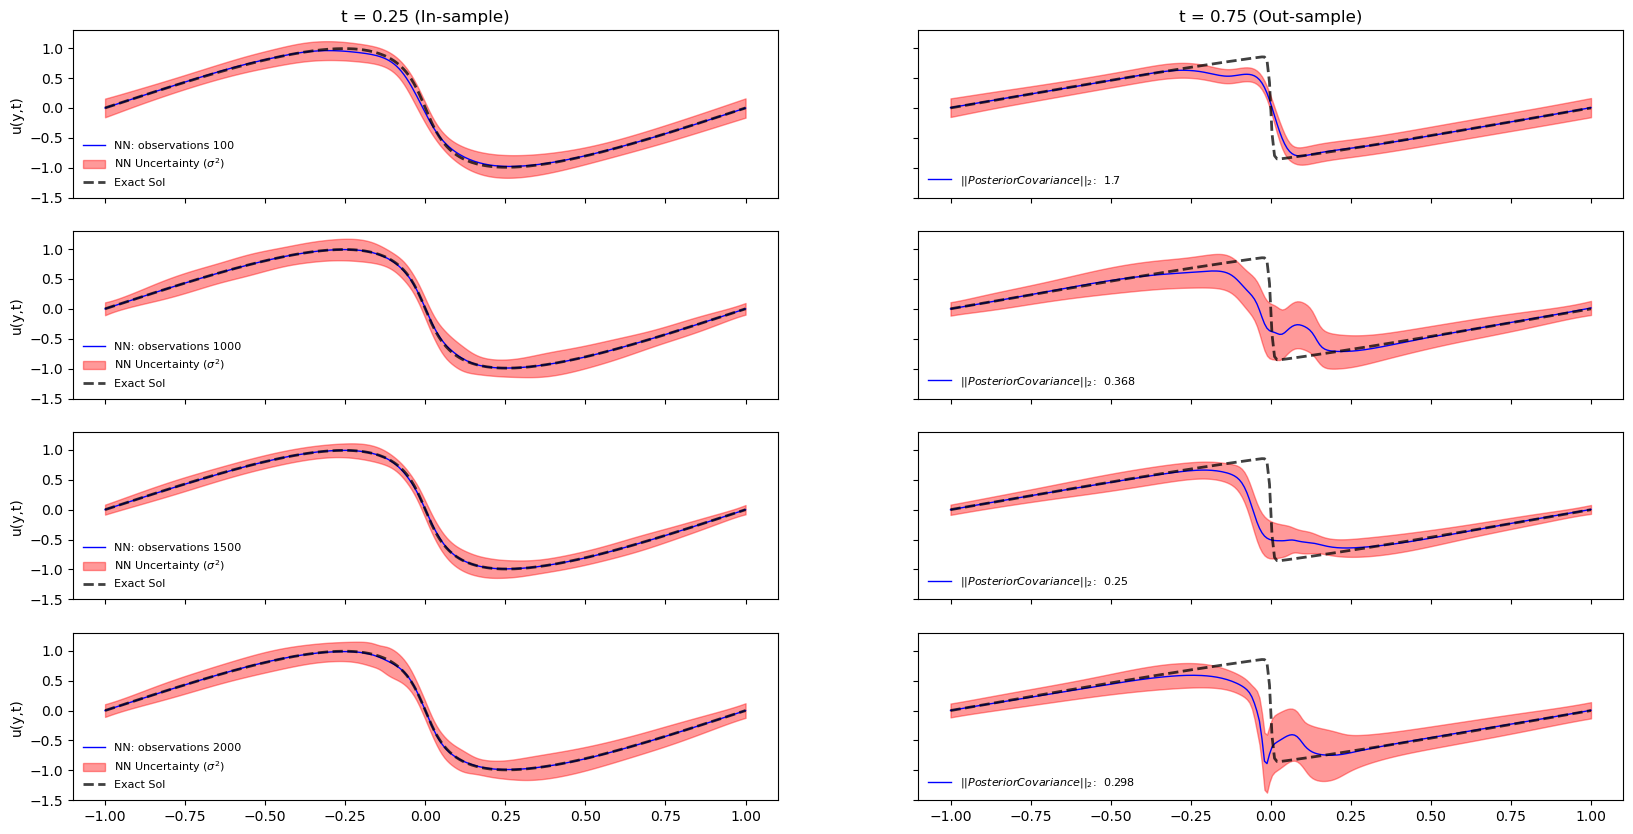

In [49]:
pr =  np.array([(0.01/np.pi)])
fig, axs = plt.subplots(4, 2, figsize=(20,10), sharey=True,sharex=True)
plt.rcParams.update({'font.size': 10})

nobs =[100,1000,1500,2000]
for counter,(llp,obs) in enumerate(zip(laplace_approx,nobs)):
        
        pcovariance = LA.norm(llp.posterior_covariance)

        X_star = torch.cat([torch.tensor(xx).reshape(-1,1),torch.tensor(yy).reshape(-1,1),torch.ones(xx.reshape(-1,1).shape)*pr],axis = 1).float()

        f_mu, f_sigma = llp(X_star)

        f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()
        

        z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.flatten(), (xx,yy), method='cubic')
        z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')
        #z_pred_var = np.sqrt(z_pred_var**2 + llp.sigma_noise.item()**2)

        z_exact = Exact

        axs[0,0].set_title(fr"t = 0.25 (In-sample)",color = "black")
        axs[counter,0].plot(x,z_pred[25,:],color = "blue", label = f"NN: observations {obs}",linewidth=1)
        axs[counter,0].fill_between(x.reshape(-1), z_pred[25,:]+z_pred_var[25,:],z_pred[25,:]-z_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
        axs[counter,0].plot(x,z_exact[25,:],linestyle = "--",alpha = 0.75,color = "black", label = "Exact Sol",linewidth=2)
        axs[counter,0].set_ylabel(r'u(y,t)')
        axs[counter,0].legend(frameon = False, prop={'size': 8},loc='lower left')

        axs[0,1].set_title(fr"t = 0.75 (Out-sample)",color = "black")
        axs[counter,1].plot(x,z_pred[75,:],color = "blue",linewidth=1, label = fr"$||Posterior Covariance||_{2}$: {pcovariance: 0.3}")
        axs[counter,1].fill_between(x.reshape(-1), z_pred[75,:]+z_pred_var[75,:],z_pred[75,:]-z_pred_var[75,:],alpha=0.4, color = "red")
        axs[counter,1].plot(x,z_exact[75,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)
        axs[counter,1].legend(frameon = False, prop={'size': 8},loc='lower left')

In [50]:
# epochs = 1200
# nobs = 2000
# lr = 0.01

# min_param , max_param,space = 0.0001, 0.05, 1

# #xx,yy = np.meshgrid(x, y)

# pde_domain,ini_c,left_bc,right_bc = data_pde_b(nobs,space,min_param,max_param)

# pde = {"PDE":["de2","ini_c2","left_bc2","right_bc2"], 
#        "data_set":{"de2" : Variable(pde_domain,requires_grad=True),
#                    "ini_c2" : ini_c,
#                    "left_bc2":left_bc,
#                    "right_bc2" :right_bc}}

In [51]:
# laplace_approxb =  []

# for layer in [2,3,4]:
#     for neuron in [20,30,40]:

#         layers = [3] + layer*[neuron] + [1]

#         model = DNN(layers)

#         model.load_state_dict(torch.load(f"../Projects-1/Physics _Informed_NN/GaLA/Gala_models/BurgEq_{layer}_{neuron}.pt"))
#         model.eval()

#         llp = llaplace(model)
#         llp.fit(pde=pde, hessian_structure = "full")
        
#         log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
#         hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
        
#         for i in range(1000):
#             hyper_optimizer.zero_grad()
#             neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
#             neg_marglik.backward(retain_graph=True)
#             hyper_optimizer.step()
#         print(f"NN: layer {layer} and neurons {neuron}, sigma {llp.sigma_noise.detach().numpy()} and prior prec {llp.prior_precision.detach().numpy()}")
        
#         laplace_approxb.append(llp)

In [52]:
# pr =  np.array([(0.01/np.pi)])
# fig, axs = plt.subplots(9, 2, figsize=(20,20), sharey=True,sharex=True)
# plt.rcParams.update({'font.size': 10})

# arch = [(2,20),(2,30),(2,40),(3,20),(3,30),(3,40),(4,20),(4,30),(4,40)]
# for counter,(llp,ar) in enumerate(zip(laplace_approxb,arch)):
#         layer, neuron = ar
        
#         pcovariance = LA.norm(llp.posterior_covariance)

#         X_star = torch.cat([torch.tensor(xx).reshape(-1,1),torch.tensor(yy).reshape(-1,1),torch.ones(xx.reshape(-1,1).shape)*pr],axis = 1).float()

#         f_mu, f_sigma = llp(X_star)

#         f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()
        

#         z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.flatten(), (xx,yy), method='cubic')
#         z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')
#         #z_pred_var = np.sqrt(z_pred_var**2 + llp.sigma_noise.item()**2)

#         z_exact = Exact

#         axs[0,0].set_title(fr"t = 0.25 (In-sample)",color = "black")
#         axs[counter,0].plot(x,z_pred[25,:],color = "blue", label = f"NN: {layer} layers, and {neuron} neurons",linewidth=1)
#         axs[counter,0].fill_between(x.reshape(-1), z_pred[25,:]+z_pred_var[25,:],z_pred[25,:]-z_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
#         axs[counter,0].plot(x,z_exact[25,:],linestyle = "--",alpha = 0.75,color = "black", label = "Exact Sol",linewidth=2)
#         axs[counter,0].set_ylabel(r'u(y,t)')
#         axs[counter,0].legend(frameon = False, prop={'size': 8},loc='lower left')

#         axs[0,1].set_title(fr"t = 0.75 (Out-sample)",color = "black")
#         axs[counter,1].plot(x,z_pred[75,:],color = "blue",linewidth=1, label = fr"$||Posterior Covariance||_{2}$: {pcovariance: 0.3}")
#         axs[counter,1].fill_between(x.reshape(-1), z_pred[75,:]+z_pred_var[75,:],z_pred[75,:]-z_pred_var[75,:],alpha=0.4, color = "red")
#         axs[counter,1].plot(x,z_exact[75,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)
#         axs[counter,1].legend(frameon = False, prop={'size': 8},loc='lower left')